Species distribution across both datasets:
taxon_species_name
Harmonia axyridis           41802
Apis mellifera              37941
Lycorma delicatula          36731
Bombus griseocollis         17059
Lymantria dispar            15888
Popillia japonica           12978
Halyomorpha halys           10075
Cicindela sexguttata         9248
Tenodera sinensis            8542
Chinavia hilaris             7545
Vespula maculifrons          5329
Graphocephala coccinea       4176
Cotinis nitida               3913
Vespula germanica            3598
Coleomegilla maculata        3367
Stagmomantis carolina        3081
Jikradia olitoria            2837
Adelges tsugae               2721
Agrilus planipennis          1272
Monochamus notatus             11
Anoplophora glabripennis        1
Name: count, dtype: int64


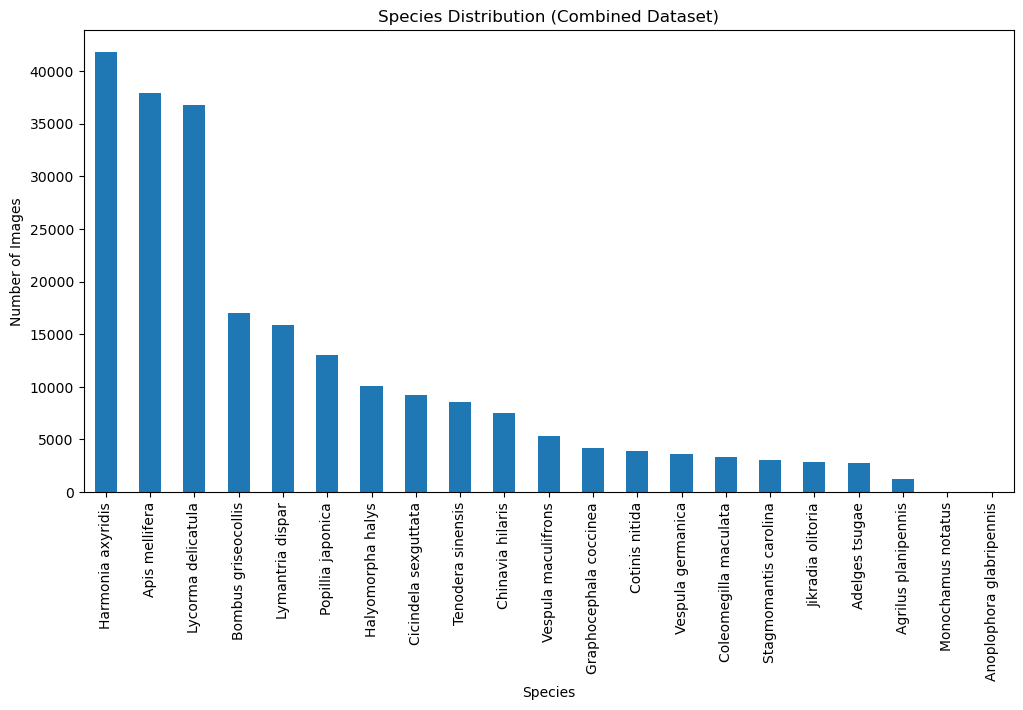

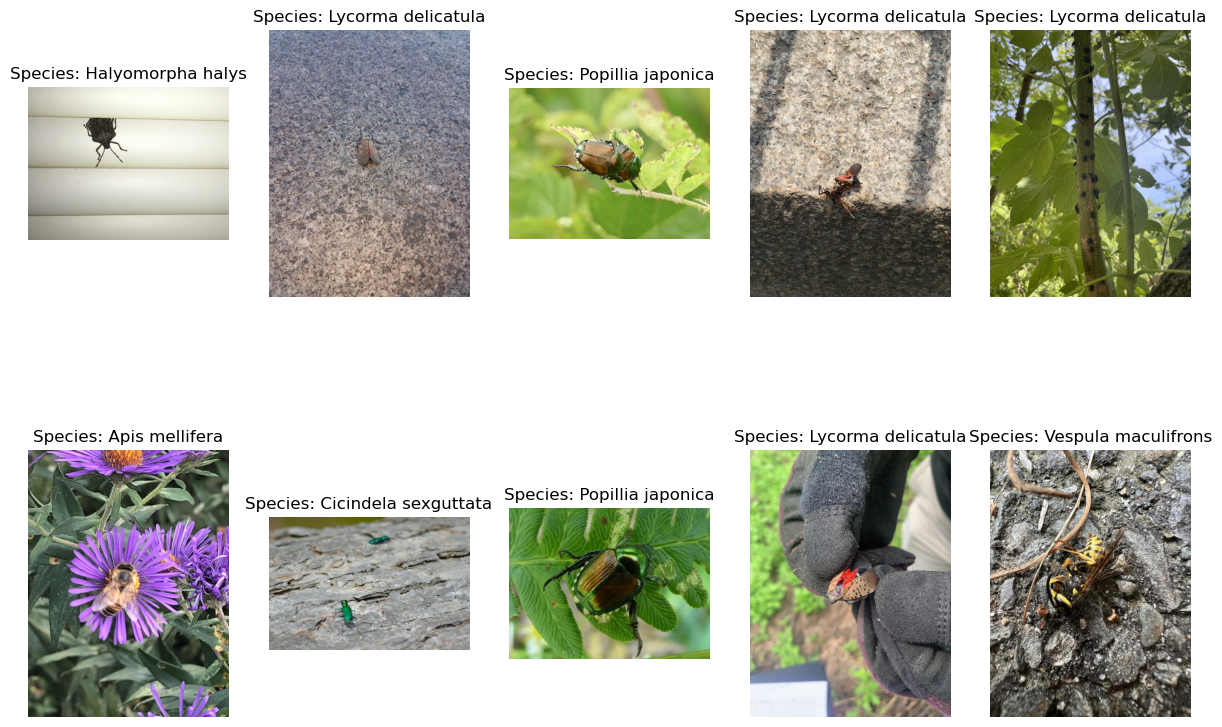

               id    taxon_species_name                 common_name
140875  195955211     Halyomorpha halys  Brown Marmorated Stink Bug
68785    96150198    Lycorma delicatula          Spotted Lanternfly
91071   126618696     Popillia japonica             Japanese Beetle
67175    94933293    Lycorma delicatula          Spotted Lanternfly
149862  222555075    Lycorma delicatula          Spotted Lanternfly
19680    34259652        Apis mellifera           Western Honey Bee
214480  160671165  Cicindela sexguttata    Six-spotted Tiger Beetle
65851    93920452     Popillia japonica             Japanese Beetle
159785  234184673    Lycorma delicatula          Spotted Lanternfly
223223  183553594   Vespula maculifrons        Eastern Yellowjacket
Species distribution after limiting the dataset:
taxon_species_name
Harmonia axyridis           500
Lymantria dispar            500
Vespula maculifrons         500
Stagmomantis carolina       500
Chinavia hilaris            500
Cotinis nitida          

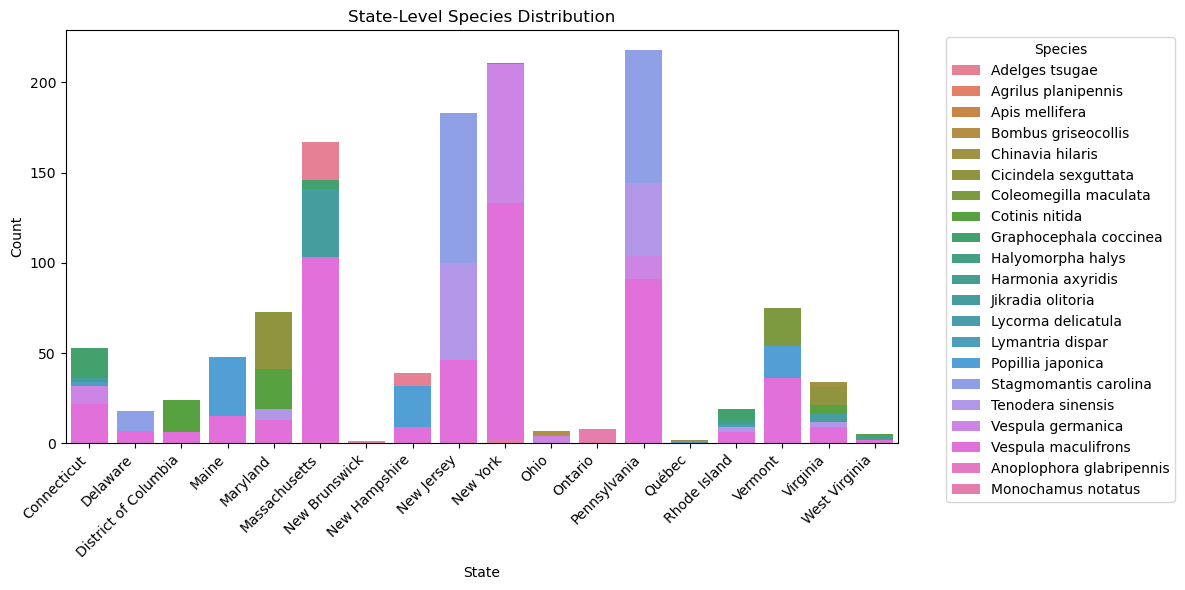

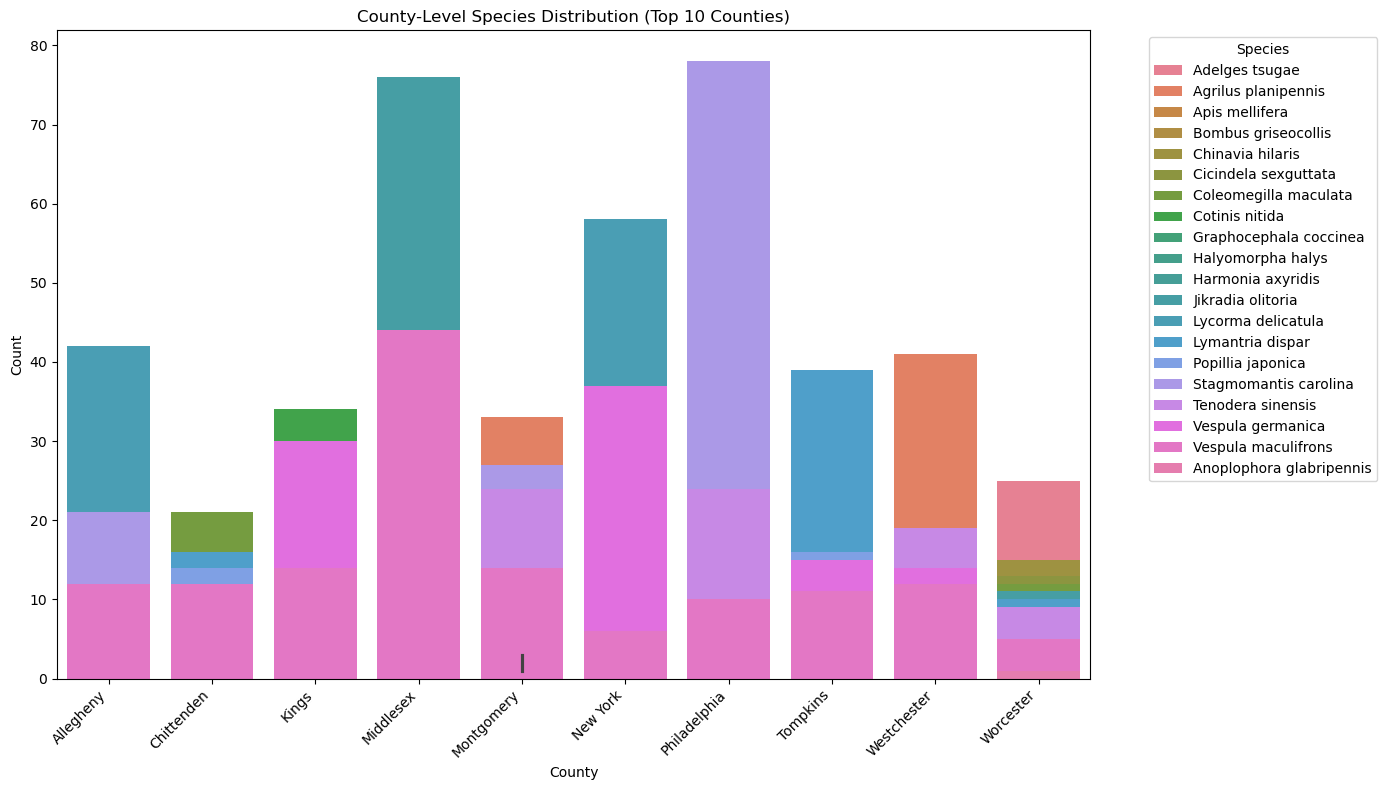

Processing Images:  49%|████▊     | 4628/9512 [1:03:16<28:58,  2.81it/s]     

Failed to load image from https://static.inaturalist.org/photos/191747894/medium.jpeg: 403 Client Error: Forbidden for url: https://static.inaturalist.org/photos/191747894/medium.jpeg


Processing Images: 100%|██████████| 9512/9512 [1:38:18<00:00,  1.61it/s]  



Baseline Performance Metrics with CustomLabelsClassifier:
  Accuracy: 87.72%
  Precision: 88.54%
  Recall: 87.72%
  F1 Score: 87.94%

Failed Predictions:
                    y_true               y_pred  \
21       Harmonia axyridis  Vespula maculifrons   
36       Harmonia axyridis    Popillia japonica   
57       Harmonia axyridis     Lymantria dispar   
60       Harmonia axyridis     Chinavia hilaris   
66       Harmonia axyridis    Popillia japonica   
...                    ...                  ...   
9183  Cicindela sexguttata    Vespula germanica   
9332  Cicindela sexguttata       Cotinis nitida   
9414  Cicindela sexguttata  Agrilus planipennis   
9423  Cicindela sexguttata    Vespula germanica   
9482  Cicindela sexguttata  Agrilus planipennis   

                                              image_url  
21    https://static.inaturalist.org/photos/11034862...  
36    https://inaturalist-open-data.s3.amazonaws.com...  
57    https://inaturalist-open-data.s3.amazonaws.com...  


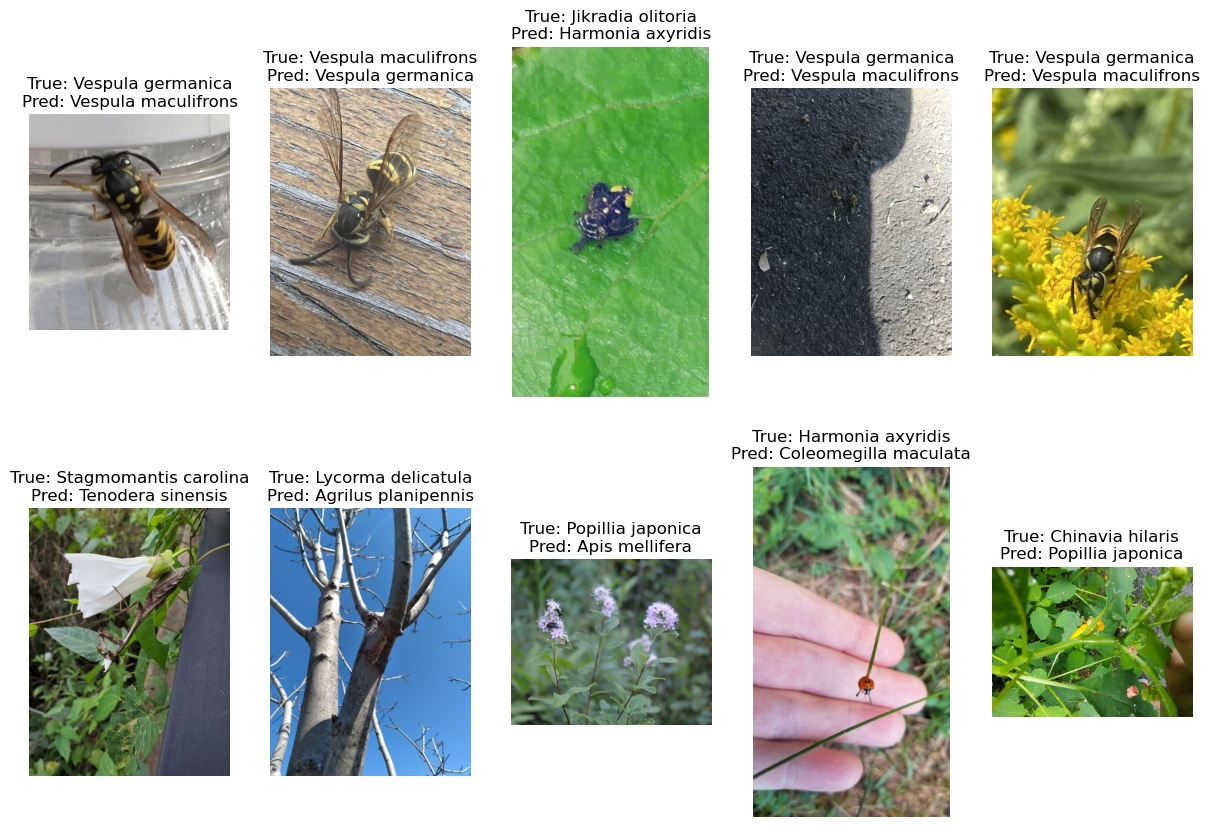

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from bioclip import CustomLabelsClassifier
import geopandas as gpd
import seaborn as sns

# Paths to the invasive and native datasets
invasive_dataset_path = r'C:\aiforcon\finalproj\northeast_invasive_insects.csv'
native_dataset_path = r'C:\aiforcon\finalproj\northeast_native_insects.csv'

# Load the datasets
invasive_df = pd.read_csv(invasive_dataset_path)
native_df = pd.read_csv(native_dataset_path)

# Combine invasive and native datasets- they have now been re-exported to have identical
# labels and more geospatial labels, and range was expanded to northeast region of U.S
combined_df = pd.concat([invasive_df, native_df], ignore_index=True)

# Define the list of species to focus on
species_list = [
    "Harmonia axyridis", "Lymantria dispar", "Agrilus planipennis",
    "Popillia japonica", "Lycorma delicatula", "Halyomorpha halys",
    "Tenodera sinensis", "Adelges tsugae", "Vespula germanica",
    "Apis mellifera", "Anoplophora glabripennis", "Graphocephala coccinea", 
    "Coleomegilla maculata", "Bombus griseocollis", "Malacosoma americanum", 
    "Cotinis nitida", "Chinavia hilaris", "Stagmomantis carolina", 
    "Vespula maculifrons", "Jikradia olitoria", "Cicindela sexguttata", "Monochamus notatus"
]

# Filter the combined dataset to include only the specified species
filtered_df = combined_df[combined_df['taxon_species_name'].isin(species_list)]

# Print dataset statistics
species_counts = filtered_df['taxon_species_name'].value_counts()
print("Species distribution across both datasets:")
print(species_counts)

# Visualize the species distribution
species_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Species Distribution (Combined Dataset)')
plt.xlabel('Species')
plt.ylabel('Number of Images')
plt.show()

# Display sample images
sample_images = filtered_df.sample(10)
plt.figure(figsize=(15, 10))

for i, row in enumerate(sample_images.itertuples(), 1):
    response = requests.get(row.image_url)
    img = Image.open(BytesIO(response.content))
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(f"Species: {row.taxon_species_name}")
    plt.axis('off')
plt.show()

print(sample_images[['id', 'taxon_species_name', 'common_name']])

# Set a ceiling for the number of images per species
ceiling = 500
limited_metadata = pd.DataFrame()

for species in species_list:
    species_data = filtered_df[filtered_df['taxon_species_name'] == species]
    if len(species_data) > ceiling:
        species_data = species_data.sample(n=ceiling, random_state=42)
    limited_metadata = pd.concat([limited_metadata, species_data])

limited_metadata.reset_index(drop=True, inplace=True)

# Print species distribution after limiting dataset size
print("Species distribution after limiting the dataset:")
print(limited_metadata['taxon_species_name'].value_counts())

# Generate state and county-level statistics
state_counts = limited_metadata.groupby(['place_state_name', 'taxon_species_name']).size().reset_index(name='count')
county_counts = limited_metadata.groupby(['place_county_name', 'place_state_name', 'taxon_species_name']).size().reset_index(name='count')

# Display state-level statistics
print("\nState-Level Species Distribution:")
print(state_counts)

# Display county-level statistics
print("\nCounty-Level Species Distribution:")
print(county_counts)

# Plot state-level distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=state_counts, x='place_state_name', y='count', hue='taxon_species_name', dodge=False)
plt.title('State-Level Species Distribution')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot county-level distribution for the top 10 counties with the most species occurrences
top_counties = county_counts.groupby(['place_county_name', 'place_state_name'])['count'].sum().nlargest(10).reset_index()
filtered_county_counts = county_counts[
    (county_counts['place_county_name'].isin(top_counties['place_county_name'])) & 
    (county_counts['place_state_name'].isin(top_counties['place_state_name']))
]

plt.figure(figsize=(14, 8))
sns.barplot(
    data=filtered_county_counts,
    x='place_county_name',
    y='count',
    hue='taxon_species_name',
    dodge=False
)
plt.title('County-Level Species Distribution (Top 10 Counties)')
plt.xlabel('County')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save temporary image path for predictions
temp_image_path = r'C:\aiforcon\finalproj\temp_image.jpg'

# Initialize the classifier
custom_classifier = CustomLabelsClassifier(species_list)

# Define performance tracking dictionary
performance = {
    "y_true": [],
    "y_pred": [],
    "image_url": []
}

# Function to download and open an image from a URL
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Failed to load image from {url}: {e}")
        return None

# Process each image in the dataset
for _, row in tqdm(limited_metadata.iterrows(), total=len(limited_metadata), desc="Processing Images"):
    image_url = row['image_url']
    ground_truth = row['taxon_species_name']

    # Load image from URL
    image = load_image_from_url(image_url)
    if image is None:
        continue  # Skip if image loading failed

    image = image.convert('RGB')

    # Save image temporarily
    image.save(temp_image_path)

    # Predict using CustomLabelsClassifier
    prediction = custom_classifier.predict(temp_image_path)
    predicted_species = prediction[0]['classification'] if prediction else None

    # Store predictions and ground truths for metric calculation
    performance["y_true"].append(ground_truth)
    performance["y_pred"].append(predicted_species)
    performance["image_url"].append(image_url)

# Calculate and display performance metrics
accuracy = accuracy_score(performance["y_true"], performance["y_pred"]) * 100
precision = precision_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
recall = recall_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
f1 = f1_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100

print(f"\nBaseline Performance Metrics with CustomLabelsClassifier:\n"
      f"  Accuracy: {accuracy:.2f}%\n"
      f"  Precision: {precision:.2f}%\n"
      f"  Recall: {recall:.2f}%\n"
      f"  F1 Score: {f1:.2f}%")

# Identify failed predictions
failed_predictions = pd.DataFrame({
    "y_true": performance["y_true"],
    "y_pred": performance["y_pred"],
    "image_url": performance["image_url"]
})
failed_predictions = failed_predictions[failed_predictions["y_true"] != failed_predictions["y_pred"]]

# Display failed predictions
print("\nFailed Predictions:")
print(failed_predictions)

# Visualize failed prediction images
if not failed_predictions.empty:
    failed_images = failed_predictions.sample(min(10, len(failed_predictions)))
    plt.figure(figsize=(15, 10))
    for i, row in enumerate(failed_images.itertuples(), 1):
        response = requests.get(row.image_url)
        img = Image.open(BytesIO(response.content))
        plt.subplot(2, 5, i)
        plt.imshow(img)
        plt.title(f"True: {row.y_true}\nPred: {row.y_pred}")
        plt.axis('off')
    plt.show()